In [1]:
import json, time, os
from datetime import datetime
import pandas as pd
import math, random
from typing import List, Set, Tuple
from Constants import DAY_END, DAY_START
DIAS_SIM = 10000
from TraficoAEP import TraficoAviones


from Montecarlo import montecarlo_dias, montecarlo_base, montecarlo_viento, montecarlo_cierre, montecarlo_politica
from TraficoAEP import TraficoAviones
from TraficoAEPCierre import TraficoAEPCerrado, AEPCerrado
from TraficoAEPViento import TraficoAEPViento  
from TraficoAEPPolitica import TraficoAvionesPolitica

OUTDIR = "outputs"
os.makedirs(OUTDIR, exist_ok=True)

def save_result(df: pd.DataFrame, meta: dict, name: str) -> str:
    ts = datetime.now().strftime("%Y%m%d-%H%M%S")
    base = f"{ts}_{name}"
    csv_path = os.path.join(OUTDIR, base + ".csv")
    json_path = os.path.join(OUTDIR, base + ".meta.json")
    df.to_csv(csv_path, index=False)
    with open(json_path, "w", encoding="utf-8") as f:
        json.dump(meta, f, ensure_ascii=False, indent=2)
    print("guardado:", csv_path)
    return csv_path


Ejercicio 3

In [2]:
def simular_una_jornada(ctrl_seed: int, lam_per_min: float) -> Tuple[List[int], List[int], int]:
    """
    Corre una jornada de 18 horas (DAY_END - DAY_START) y devuelve:
    - aterrizajes_por_hora: lista de enteros con aterrizajes por hora
    - arribos_por_hora: lista de enteros con 'apariciones' por hora (arrivals del Poisson)
    - desviados: cantidad de aviones que terminaron 'diverted' en el día
    """
    ctrl = TraficoAviones(seed=ctrl_seed) # cambia la seed porque cada día es independiente del otro
    apariciones = set(ctrl.bernoulli_aparicion(lam_per_min, t0=DAY_START, t1=DAY_END)) 

    num_horas = (DAY_END - DAY_START) // 60
    # inicializo dos listas con ceros de longitud num_horas
    aterrizajes_por_hora = [0] * num_horas
    arribos_por_hora = [0] * num_horas

    # contar arribos por hora directamente desde las apariciones (Poisson)
    for t in apariciones:
        h = (t - DAY_START) // 60 # min en el que aparece, convertido a hora (le resto DAY_START por si no es 0 como lo tomamos nosotros, ej 6am)
        if 0 <= h < num_horas: # chequeo que esté en el rango válido
            arribos_por_hora[h] += 1

    prev_landed: Set[int] = set() # aviones que ya habían aterrizado para después no tomarlos en cuenta

    def landed_set() -> Set[int]:
        return {aid for aid in ctrl.inactivos if ctrl.planes[aid].estado == "landed"}

    def diverted_set() -> Set[int]:
        return {aid for aid in ctrl.inactivos if ctrl.planes[aid].estado == "diverted"}

    for t in range(DAY_START, DAY_END):
        ctrl.step(t, aparicion=(t in apariciones))

        now_landed = landed_set()
        nuevos_landed = now_landed - prev_landed # me quedo con los que aterrizaron justo en este minuto
        if nuevos_landed:
            h = (t - DAY_START) // 60
            if 0 <= h < num_horas:
                aterrizajes_por_hora[h] += len(nuevos_landed)
        prev_landed = now_landed

    total_diverted = len(diverted_set())
    return aterrizajes_por_hora, arribos_por_hora, total_diverted


def ic95_proporcion(p_sombrero: float, n: int) -> Tuple[float, float]:
    '''
    devuelve el intervalo de confianza al 95% para una proporción p_sombrero
    p_sombrero: proporción muestral
    n: tamaño de la muestra
    '''
    if n == 0:
        return (float("nan"), float("nan"))
    # misma fórmula, escrita más explícita
    se = math.sqrt(p_sombrero * (1 - p_sombrero) / n) # standard error
    # 1.96 es el z* para 95% (distribución normal estándar)
    low = max(0.0, p_sombrero - 1.96 * se) 
    high = min(1.0, p_sombrero + 1.96 * se)
    return low, high


def montecarlo_dias_3(lam_per_min: float = 1.0/60.0, dias: int = DIAS_SIM, seed: int = 12345):
    """
    Corre Monte Carlo por 'dias' o jornadas (18h c/u) y estima:
    - p_landed(X=5): prob. de exactamente 5 aterrizajes en una hora del sistema
    - p_arrivals(Y=5): prob. de exactamente 5 arribos Poisson en una hora
    - IC 95% para ambas
    También reporta desvíos totales.
    """
    rng = random.Random(seed)
    horas_totales = 0
    horas_con_5_landed = 0
    horas_con_5_arrivals = 0
    desviados_totales = 0

    muestra_horas_landed: List[int] = []
    muestra_horas_arrivals: List[int] = []

    for _ in range(dias):
        ctrl_seed = rng.randrange(1_000_000_000) # nueva seed para cada día
        aterr_por_hora, arribos_por_hora, desviados = simular_una_jornada(ctrl_seed, lam_per_min)
        desviados_totales += desviados

        # x_l son los aterrizajes/landings en una hora, x_a los arribos/arrivals en esa misma hora
        for x_l, x_a in zip(aterr_por_hora, arribos_por_hora):
            horas_totales += 1
            muestra_horas_landed.append(x_l)
            muestra_horas_arrivals.append(x_a)
            if x_l == 5:
                horas_con_5_landed += 1 #contador para metricas
            if x_a == 5:
                horas_con_5_arrivals += 1 #idem

    p_landed = horas_con_5_landed / horas_totales if horas_totales else float("nan") 
    p_arrivals = horas_con_5_arrivals / horas_totales if horas_totales else float("nan")
    ic_landed = ic95_proporcion(p_landed, horas_totales)
    ic_arrivals = ic95_proporcion(p_arrivals, horas_totales)

    print(f"=== Monte Carlo {dias} días ===")
    print(f"λ por minuto: {lam_per_min:.6f}  (≈ {lam_per_min*60:.3f} arribos esperados por hora)")
    print(f"Días simulados: {dias}")
    print(f"Horas totales: {horas_totales}")
    print(f"[LAND] Horas con exactamente 5 aterrizajes: {horas_con_5_landed}")
    print(f"[LAND] p(X=5) = {p_landed:.6f}  IC95%: [{ic_landed[0]:.6f}, {ic_landed[1]:.6f}]")
    print(f"[ARR ] Horas con exactamente 5 arribos:     {horas_con_5_arrivals}")
    print(f"[ARR ] p(Y=5) = {p_arrivals:.6f}  IC95%: [{ic_arrivals[0]:.6f}, {ic_arrivals[1]:.6f}]")
    print(f"Desvíos totales en {dias} días: {desviados_totales}")

    return {
        "landings": {
            "p_5": p_landed,
            "ic95": ic_landed,
            "horas_totales": horas_totales,
            "horas_con_5": horas_con_5_landed,
            "muestra_horas": muestra_horas_landed,
        },
        "arrivals": {
            "p_5": p_arrivals,
            "ic95": ic_arrivals,
            "horas_totales": horas_totales,
            "horas_con_5": horas_con_5_arrivals,
            "muestra_horas": muestra_horas_arrivals,
        },
        "desviados_totales": desviados_totales,
    }


if __name__ == "__main__":
    # probamos con distintas cantidades de días (lambda fijo: 1/60 = 1 por hora)
    dias = [30, 90, 500, 1000, 5000, 10000, 20000]
    for d in dias:
        montecarlo_dias_3(lam_per_min=1.0/60.0, dias=d, seed=2025)

=== Monte Carlo 30 días ===
λ por minuto: 0.016667  (≈ 1.000 arribos esperados por hora)
Días simulados: 30
Horas totales: 540
[LAND] Horas con exactamente 5 aterrizajes: 0
[LAND] p(X=5) = 0.000000  IC95%: [0.000000, 0.000000]
[ARR ] Horas con exactamente 5 arribos:     0
[ARR ] p(Y=5) = 0.000000  IC95%: [0.000000, 0.000000]
Desvíos totales en 30 días: 26
=== Monte Carlo 90 días ===
λ por minuto: 0.016667  (≈ 1.000 arribos esperados por hora)
Días simulados: 90
Horas totales: 1620
[LAND] Horas con exactamente 5 aterrizajes: 0
[LAND] p(X=5) = 0.000000  IC95%: [0.000000, 0.000000]
[ARR ] Horas con exactamente 5 arribos:     4
[ARR ] p(Y=5) = 0.002469  IC95%: [0.000052, 0.004886]
Desvíos totales en 90 días: 58
=== Monte Carlo 500 días ===
λ por minuto: 0.016667  (≈ 1.000 arribos esperados por hora)
Días simulados: 500
Horas totales: 9000
[LAND] Horas con exactamente 5 aterrizajes: 15
[LAND] p(X=5) = 0.001667  IC95%: [0.000824, 0.002509]
[ARR ] Horas con exactamente 5 arribos:     19
[ARR 

In [3]:
lams = [0.02, 0.1, 0.2, 0.5, 1]

In [4]:

df_base = montecarlo_base(lams=lams, dias=DIAS_SIM, seed=123)
save_result(df_base, {"scenario":"base", "lams":lams, "dias":DIAS_SIM, "seed":123}, "base_mc")
df_base.head()


guardado: outputs\20250921-182604_base_mc.csv


,lam,congestion_rate_mean,congestion_rate_ci_low,congestion_rate_ci_high,avg_delay_min_mean,avg_delay_min_ci_low,avg_delay_min_ci_high,divert_rate_mean,divert_rate_ci_low,divert_rate_ci_high,avg_arrivals_per_day,avg_diverted_per_day,dias
0,0.02,0.019164,0.018748,0.019579,0.132791,0.128770,0.136813,0.036487,0.035717,0.037256,21.6004,0.8233,10000
1,0.10,0.090873,0.090499,0.091248,1.549079,1.536410,1.561748,0.162353,0.161744,0.162963,108.0331,17.6701,10000
2,0.20,0.161839,0.161523,0.162154,5.413217,5.391099,5.435334,0.320373,0.319837,0.320909,215.8647,69.4344,10000
3,0.50,0.304221,0.304000,0.304443,8.663326,8.640966,8.685686,0.678579,0.678359,0.678799,539.9986,366.5754,10000
4,1.00,0.386164,0.386164,0.386164,2.288083,2.288083,2.288083,0.813889,0.813889,0.813889,1080.0000,879.0000,10000


In [5]:
kw = {"p_goaround": 0.10, "final_threshold_nm": 2.5}
df_wind = montecarlo_dias(
    lams=lams, dias = DIAS_SIM, seed=123,
    Controller=TraficoAEPViento, controller_kwargs=kw
)
df_wind["scenario"] = "viento"
save_result(df_wind, {"scenario":"viento", "kwargs":kw, "lams":lams, "dias":DIAS_SIM, "seed":123}, "viento_mc")
df_wind.head()

guardado: outputs\20250921-200051_viento_mc.csv


,lam,congestion_rate_mean,congestion_rate_ci_low,congestion_rate_ci_high,avg_delay_min_mean,avg_delay_min_ci_low,avg_delay_min_ci_high,divert_rate_mean,divert_rate_ci_low,divert_rate_ci_high,avg_arrivals_per_day,avg_diverted_per_day,dias,scenario
0,0.02,0.019499,0.019085,0.019913,0.413725,0.404225,0.423226,0.036487,0.035717,0.037256,21.6004,0.8233,10000,viento
1,0.10,0.092001,0.091634,0.092368,3.151971,3.128974,3.174968,0.163876,0.163263,0.164490,108.0331,17.8421,10000,viento
2,0.20,0.164124,0.163811,0.164437,8.802100,8.768984,8.835217,0.344738,0.344143,0.345333,215.8647,74.7368,10000,viento
3,0.50,0.306701,0.306482,0.306920,10.477438,10.449740,10.505136,0.701688,0.701456,0.701920,539.9986,379.0425,10000,viento
4,1.00,0.390135,0.389816,0.390453,2.959801,2.913515,3.006087,0.833816,0.833605,0.834028,1080.0000,900.5218,10000,viento


In [13]:
import importlib
import Simulacion, TraficoAEPCierre, Montecarlo

importlib.reload(Simulacion)
importlib.reload(TraficoAEPCierre)
importlib.reload(Montecarlo)

closure = AEPCerrado(start_min=180, dur_min=30)
kwargs_cierre = {"closure": closure}

meta = {
    "scenario": "cierre",
    "kwargs": {
        "closure": {"start_min": closure.start_min, "dur_min": closure.dur_min}
    },
    "lams": lams, "dias": DIAS_SIM, "seed": 123
}

df_close = montecarlo_dias(
    lams=lams, dias=DIAS_SIM, seed=123,
    Controller=TraficoAEPCerrado, controller_kwargs=kwargs_cierre
)

df_close["scenario"] = "cierre"
save_result(df_close, meta, "cierre_mc")
df_close.head()


guardado: outputs\20250921-222215_cierre_mc.csv


,lam,congestion_rate_mean,congestion_rate_ci_low,congestion_rate_ci_high,avg_delay_min_mean,avg_delay_min_ci_low,avg_delay_min_ci_high,divert_rate_mean,divert_rate_ci_low,divert_rate_ci_high,avg_arrivals_per_day,avg_diverted_per_day,dias,scenario
0,0.02,0.020520,0.020109,0.020931,0.609965,0.595047,0.624883,0.036487,0.035717,0.037256,21.6004,0.8233,10000,cierre
1,0.10,0.092056,0.091687,0.092424,2.443327,2.424676,2.461978,0.163460,0.162845,0.164075,108.0331,17.7942,10000,cierre
2,0.20,0.163011,0.162697,0.163325,6.570059,6.546148,6.593970,0.330437,0.329887,0.330987,215.8647,71.6166,10000,cierre
3,0.50,0.304571,0.304350,0.304791,9.251172,9.227862,9.274483,0.685650,0.685432,0.685868,539.9986,370.3919,10000,cierre
4,1.00,0.330251,0.330251,0.330251,1.417400,1.417400,1.417400,0.828704,0.828704,0.828704,1080.0000,895.0000,10000,cierre


In [11]:
from Montecarlo import montecarlo_politica
import pandas as pd

import importlib, TraficoAEPPolitica, Simulacion, Montecarlo
importlib.reload(TraficoAEPPolitica)
importlib.reload(Simulacion)
importlib.reload(Montecarlo)

LAMBDAS = [0.02, 0.1, 0.2, 0.5, 1]
SEED = 123

df_politica = montecarlo_politica(LAMBDAS, dias=DIAS_SIM, seed=SEED)
df_politica["scenario"] = "politica"

df_politica.to_csv("politica_mc.csv", index=False)
df_politica.head()

KeyboardInterrupt: 

In [ ]:
from Montecarlo import montecarlo_politica2a
import pandas as pd

import importlib, TraficoAEPPolitica, Simulacion, Montecarlo
importlib.reload(TraficoAEPPolitica)
importlib.reload(Simulacion)
importlib.reload(Montecarlo)

LAMBDAS = [0.02, 0.1, 0.2, 0.5, 1]
SEED = 123

df_politica = montecarlo_politica2a(LAMBDAS, dias=DIAS_SIM, seed=SEED)
df_politica["scenario"] = "politica2a"

meta = {"scenario": "politica2a", "lams": LAMBDAS, "dias": DIAS_SIM, "seed": SEED}
save_result(df_politica, meta, "politica2a_mc")
df_politica.head()

guardado: outputs\20250921-165713_politica2a_mc.csv


,lam,congestion_rate_mean,congestion_rate_ci_low,congestion_rate_ci_high,avg_delay_min_mean,avg_delay_min_ci_low,avg_delay_min_ci_high,divert_rate_mean,divert_rate_ci_low,divert_rate_ci_high,avg_arrivals_per_day,avg_diverted_per_day,dias,scenario
0,0.02,0.021195,0.018136,0.024255,0.162586,0.127529,0.197643,0.036646,0.031244,0.042048,21.710,0.825,200,politica2a
1,0.10,0.089529,0.087066,0.091992,1.549081,1.461334,1.636828,0.161046,0.156620,0.165473,108.565,17.630,200,politica2a
2,0.20,0.160091,0.157767,0.162415,5.340367,5.175618,5.505117,0.320116,0.316407,0.323825,216.070,69.450,200,politica2a
3,0.50,0.304228,0.302688,0.305767,8.627161,8.469533,8.784789,0.678468,0.676873,0.680063,538.870,365.775,200,politica2a
4,1.00,0.386164,0.386164,0.386164,2.288083,2.288083,2.288083,0.813889,0.813889,0.813889,1080.000,879.000,200,politica2a


In [12]:
from Montecarlo import montecarlo_politica2b
import pandas as pd

import importlib, TraficoAEPPolitica, Simulacion, Montecarlo
importlib.reload(TraficoAEPPolitica)
importlib.reload(Simulacion)
importlib.reload(Montecarlo)

LAMBDAS = [0.02, 0.1, 0.2, 0.5, 1]
SEED = 123

df_politica = montecarlo_politica2b(LAMBDAS, dias=DIAS_SIM, seed=SEED)
df_politica["scenario"] = "politica2b"

meta = {"scenario": "politica2b", "lams": LAMBDAS, "dias": DIAS_SIM, "seed": SEED}
save_result(df_politica, meta, "politica2b_mc")
df_politica.head()

KeyboardInterrupt: 

In [ ]:
from Montecarlo import montecarlo_base, montecarlo_viento, montecarlo_cierre, montecarlo_politica
import pandas as pd

# no volvamos a correr todo!!
# lams = [0.02, 0.1, 0.2, 0.5, 1.0]
# dias = DIAS_SIM
# seed = 123
# df_base = montecarlo_base(lams, dias=dias, seed=seed).assign(scenario="base")
# df_viento = montecarlo_viento(lams, dias=dias, seed=seed, p_goaround = 0.10, final_threshold_nm=2.5).assign(scenario = "viento")
# df_cierre = montecarlo_cierre(lams, dias=dias, seed=seed, start_min=180, dur_min=30).assign(scenario="cierre")
# df_pol    = montecarlo_politica(lams, dias=dias, seed=seed, buffer_anticipacion=0.5).assign(scenario="politica")
# df_pol2a = montecarlo_politica2a(lams, dias=dias, seed=seed).assign(scenario="politica2a")
# df_pol2b = montecarlo_politica2b(lams, dias=dias, seed=seed).assign(scenario="politica2b")

df_base = pd.read_csv("outputs/20250921-165205_base_mc.csv")
df_base["scenario"] = "base"
df_viento = pd.read_csv("outputs/20250921-165303_viento_mc.csv")
df_viento["scenario"] = "viento"
################# los csvs estos hay que cambiarlos por los que corramos ultimos (cata cambió cierre)
df_cierre = pd.read_csv("outputs/20250921-222215_cierre_mc.csv")
df_cierre["scenario"] = "cierre"
df_pol = pd.read_csv("outputs/politica_mc.csv")
df_pol["scenario"] = "politica"
df_pol2a = pd.read_csv("outputs/20250921-211128_politica2a_mc.csv")
df_pol2a["scenario"] = "politica2a"
df_pol2b = pd.read_csv("outputs/.csv")
df_pol2b["scenario"] = "politica2b"

df_all = pd.concat([df_base, df_viento, df_cierre, df_pol, df_pol2a, df_pol2b], ignore_index=True)

df_all.head()

KeyboardInterrupt: 

SOLO BASE (EJ 4)

(<Figure size 700x400 with 1 Axes>,
 <Axes: title={'center': 'Congestión vs λ'}, xlabel='λ (arribos por minuto)', ylabel='Proporción de minutos en congestión'>)

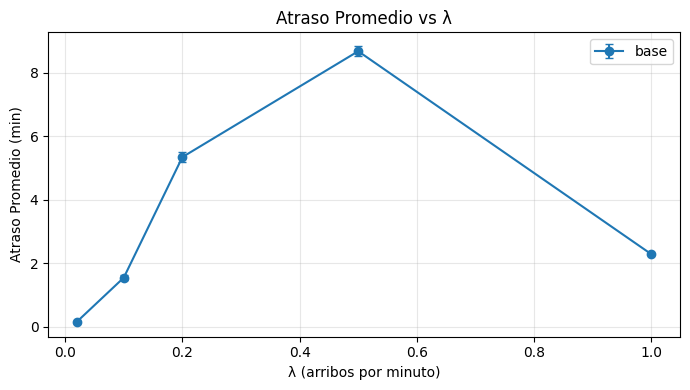

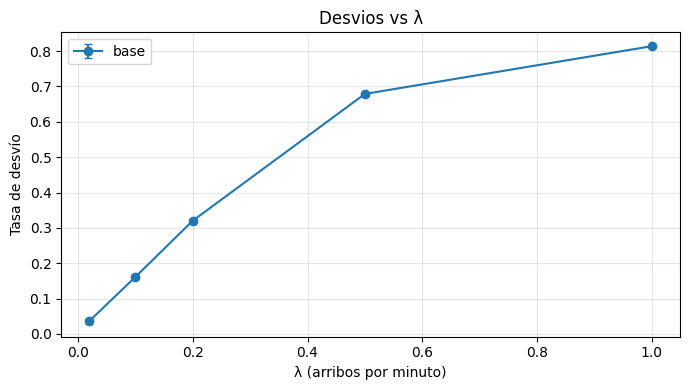

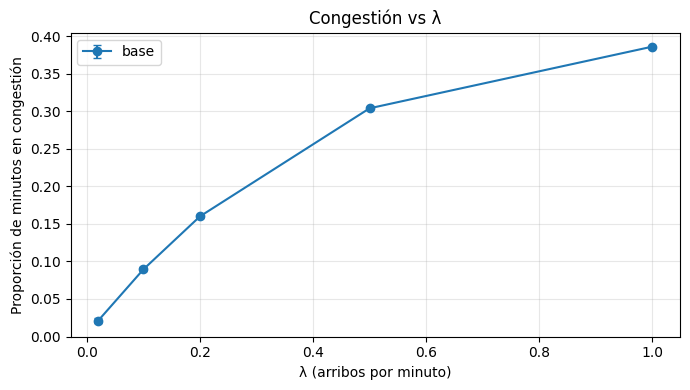

In [ ]:
import Plots as V

V.plot_metric_vs_lambda(df_base, metric = "avg_delay_min",
                        ylabel= "Atraso Promedio (min)",
                        title= "Atraso Promedio vs λ",
                        outname="delay_vs_lambda")


V.plot_metric_vs_lambda(df_base, metric = "divert_rate",
                        ylabel= "Tasa de desvío",
                        title= "Desvios vs λ",
                        outname="diverts_vs_lambda")


V.plot_metric_vs_lambda(df_base, metric = "congestion_rate",
                        ylabel= "Proporción de minutos en congestión",
                        title= "Congestión vs λ",
                        outname="congestion_vs_lambda")

BASE VS VIENTO

(<Figure size 700x400 with 1 Axes>,
 <Axes: title={'center': 'Congestión vs λ'}, xlabel='λ (arribos por minuto)', ylabel='Proporción de minutos en congestión'>)

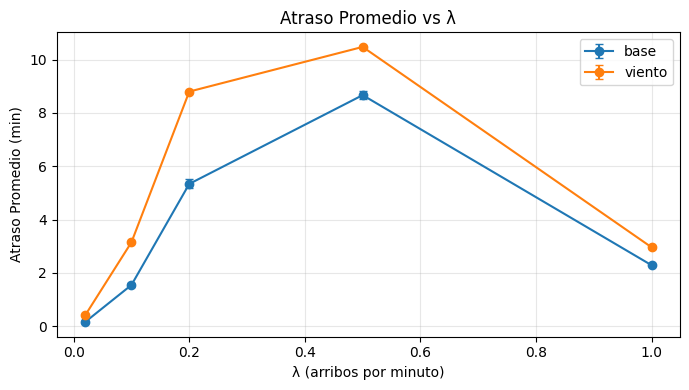

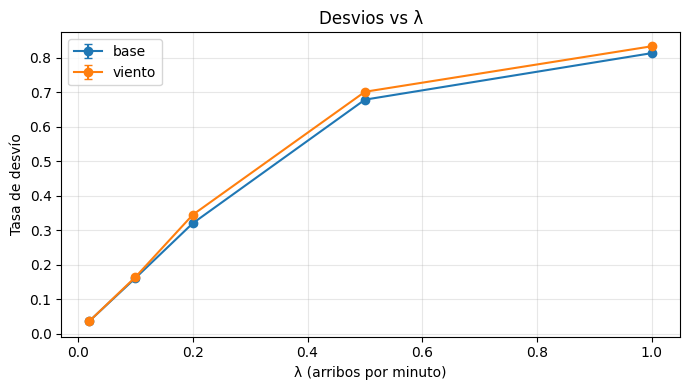

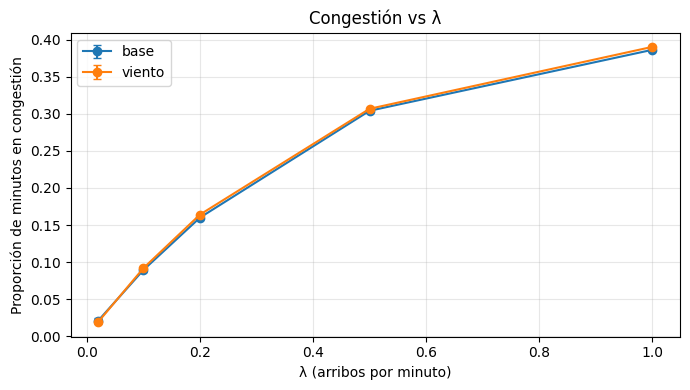

In [ ]:

import Plots as V

df_base_viento = pd.concat([df_base, df_viento], ignore_index=True)

V.plot_metric_vs_lambda(df_base_viento, metric = "avg_delay_min",
                        ylabel= "Atraso Promedio (min)",
                        title= "Atraso Promedio vs λ",
                        outname="delay_vs_lambda")


V.plot_metric_vs_lambda(df_base_viento, metric = "divert_rate",
                        ylabel= "Tasa de desvío",
                        title= "Desvios vs λ",
                        outname="diverts_vs_lambda")


V.plot_metric_vs_lambda(df_base_viento, metric = "congestion_rate",
                        ylabel= "Proporción de minutos en congestión",
                        title= "Congestión vs λ",
                        outname="congestion_vs_lambda")

BASE VS CIERRE

(<Figure size 700x400 with 1 Axes>,
 <Axes: title={'center': 'Congestión vs λ'}, xlabel='λ (arribos por minuto)', ylabel='Proporción de minutos en congestión'>)

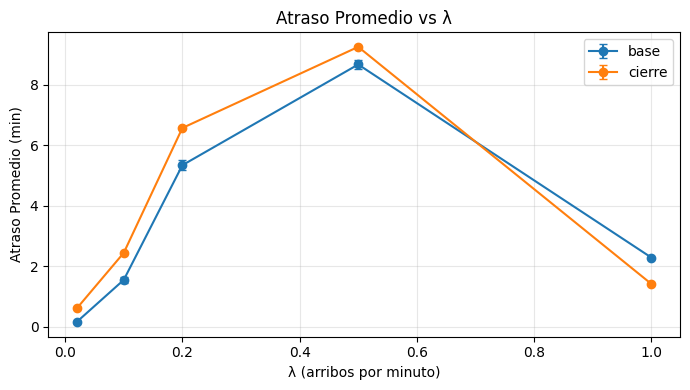

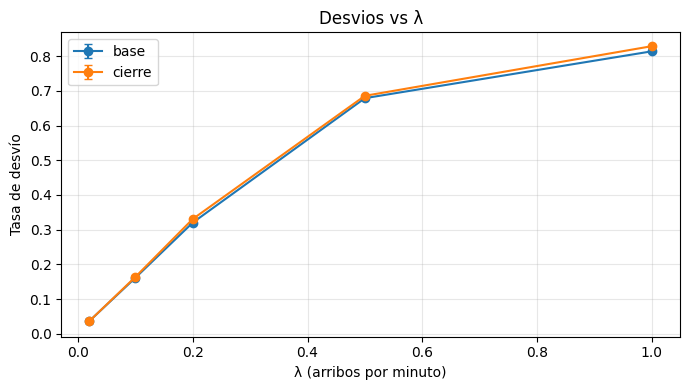

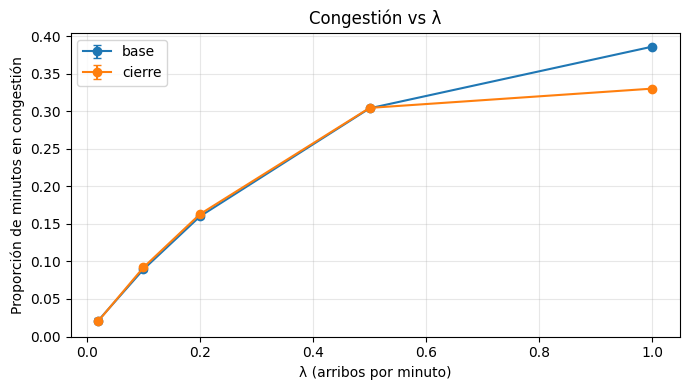

In [ ]:

import Plots as V

df_base_cierre = pd.concat([df_base, df_cierre], ignore_index=True)

V.plot_metric_vs_lambda(df_base_cierre, metric = "avg_delay_min",
                        ylabel= "Atraso Promedio (min)",
                        title= "Atraso Promedio vs λ",
                        outname="delay_vs_lambda")


V.plot_metric_vs_lambda(df_base_cierre, metric = "divert_rate",
                        ylabel= "Tasa de desvío",
                        title= "Desvios vs λ",
                        outname="diverts_vs_lambda")


V.plot_metric_vs_lambda(df_base_cierre, metric = "congestion_rate",
                        ylabel= "Proporción de minutos en congestión",
                        title= "Congestión vs λ",
                        outname="congestion_vs_lambda")

BASE VS POLITICAS

In [ ]:
# graficar comparativa base vs politicas
import Plots as V
df_combined = pd.concat([df_base, df_pol, df_pol2a, df_pol2b], ignore_index=True)
V.plot_metric_vs_lambda(
    df_combined,
    metric="avg_delay_min",
    ylabel="Atraso Promedio (min)",
    title="Atraso Promedio vs λ — base vs politicas",
    outname="delay_vs_lambda_base_vs_politicas"
)

V.plot_metric_vs_lambda(
    df_combined,
    metric="divert_rate",
    ylabel="Tasa de desvío",
    title="Desvíos vs λ — base vs politicas",
    outname="diverts_vs_lambda_base_vs_politicas"
)

V.plot_metric_vs_lambda(
    df_combined,
    metric="congestion_rate",
    ylabel="Proporción de minutos en congestión",
    title="Congestión vs λ — base vs politicas",
    outname="congestion_vs_lambda_base_vs_politicas"
)

COMPARATIVA DE TODOS

(<Figure size 700x400 with 1 Axes>,
 <Axes: title={'center': 'Congestión vs λ'}, xlabel='λ (arribos por minuto)', ylabel='Proporción de minutos en congestión'>)

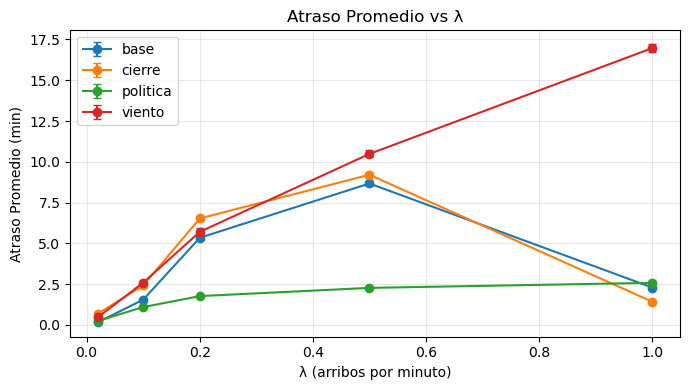

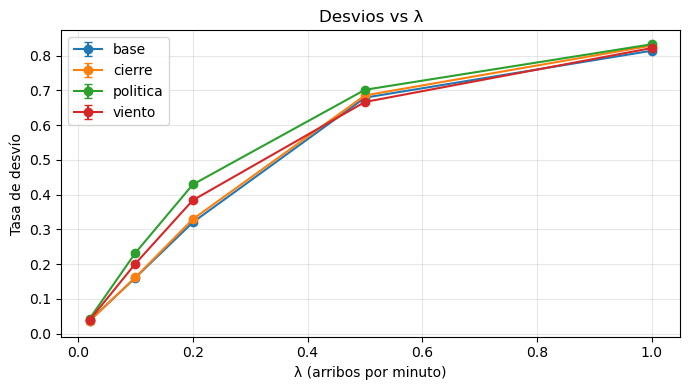

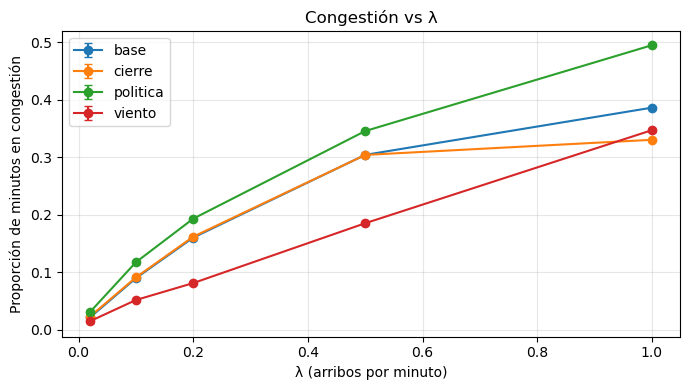

In [ ]:
import Plots as V

V.plot_metric_vs_lambda(df_all, metric = "avg_delay_min",
                        ylabel= "Atraso Promedio (min)",
                        title= "Atraso Promedio vs λ",
                        outname="delay_vs_lambda")


V.plot_metric_vs_lambda(df_all, metric = "divert_rate",
                        ylabel= "Tasa de desvío",
                        title= "Desvios vs λ",
                        outname="diverts_vs_lambda")


V.plot_metric_vs_lambda(df_all, metric = "congestion_rate",
                        ylabel= "Proporción de minutos en congestión",
                        title= "Congestión vs λ",
                        outname="congestion_vs_lambda")

